---
# <div align="center">**MAPIE CLF MULTI-CLASS TUTORIAL**</div>  
---  
### **A. THÔNG TIN CHUNG**
- **Tutorial Notebook:** Tác giả làm mẫu cách thực hành áp dụng Mapie Classification để giải quyết vấn đề ĐỘ TIN CẬY cho các mô hình phân loại 
- **Mô hình áp dụng**: Cho cả phân loại nhị phân (Binary) và phân loại đa nhãn (Multi class)

### **B. BỘ DỮ LIỆU THỰC HÀNH**
- Notebook này như 1 quick-guide for understanding
- Tác giả TỰ MÔ PHỎNG bộ dữ liệu, để mọi người có thể tự chạy lại code nhanh
- Tự thay số để hiểu cách kết quả thay đổi như thế nào
  
### **C. NỘI DUNG CHÍNH** ###
- ##### **THIẾT LẬP DỰ ÁN**
    - Cài đặt thư viện
    - Cài đặt trực quan
- ##### **MÔ PHỎNG BỘ DỮ LIỆU ẢO**
    - Mô phỏng bộ dữ liệu ảo có tương quan, phù hợp thực tế
- ##### **MÔ HÌNH PHÂN LOẠI**
    - Lưu ý ở bước Split Data
    - Mô hình lõi
    - Độ chính xác cắt ngưỡng cứng
- ##### **MAPIE CLF UNDERSTANDING**
    - Thuật toán cắt ngưỡng linh hoạt
    - Fit model
    - Prediction set
    - Phân tích & Kết luận

---
# <div align="center">**0. THIẾT LẬP DỰ ÁN**</div>  
---  

## **0.1: CÀI ĐẶT THƯ VIỆN**
- **NHẬP TẤT CẢ THƯ VIỆN CẦN THIẾT CHO TOÀN BỘ DỰ ÁN**   
    - Nếu lỗi thiếu thư viện, tải thêm thư viện tương ứng 

In [1]:
# pip install numpy                                  
# pip install pandas
# pip install matplotlib
# pip install seaborn
# pip install statsmodels
# pip install scikit-learn
# pip install xgboost
# pip install //etc...etc...//

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay

---
## **0.2: CÀI ĐẶT TRỰC QUAN HÓA**
- **KHÔNG CẦN QUAN TÂM, SKIP**

In [3]:
from matplotlib.colors import LinearSegmentedColormap

# Hiển thị đầy đủ bảng với thanh trượt ngang
pd.set_option('display.max_columns', None)   

# Tạo colormap trắng → xanh lục
custom_green = LinearSegmentedColormap.from_list("custom_green", ["#ffffff", "#00cc66"])

# Hnàm tô màu
def highlight_warning_full(row):
    styles = [""] * len(row)
    col_idx = row.index.tolist()

    # Index các cột
    idx_y = col_idx.index("y true") if "y true" in col_idx else None
    idx_set = col_idx.index("Prediction Set") if "Prediction Set" in col_idx else None
    idx_correct = col_idx.index("Correct in set") if "Correct in set" in col_idx else None
    idx_size = col_idx.index("Set size") if "Set size" in col_idx else None

    # Điều kiện tô màu chính
    if idx_y is not None and idx_set is not None and idx_correct is not None:
        if not row["Correct in set"]:
            color = "background-color: #f8696b; color: black; font-weight: bold"  # đỏ
        elif row["Set size"] == 1:
            color = "background-color: #00cc66; color: black; font-weight: bold"  # xanh lục
        else:
            color = "background-color: yellow; color: black; font-weight: bold"  # vàng

        styles[idx_y] = color
        styles[idx_set] = color
        styles[idx_correct] = color

    # Cột Set size
    if idx_size is not None:
        if row["Set size"] == 1:
            styles[idx_size] = "background-color: white; color: black; font-weight: bold"
        else:
            styles[idx_size] = "background-color: #b590ff; color: black; font-weight: bold"

    return styles

---
# <div align="center">**1. MÔ PHỎNG BỘ DỮ LIỆU ẢO**</div>   
---

## **1.0: KHÔNG CẦN QUAN TÂM**

## **1.1: SKIP THẲNG ĐỂN PHẦN 2: MÔ HÌNH PHÂN LOẠI**

## **1.2: MÔ PHỎNG BỘ DỮ LIỆU**
- **Ý TƯỞNG:**
    - Ngữ cảnh: Thời điểm cần làm Demo, tác giả không tìm được bộ dữ liệu KPI từ các nguồn web phổ thông, tự nghĩ ra cách mô phỏng "dùng tạm" này 
    - Cách thức: Tác giả khởi tạo bộ dữ liệu bằng phân phối ngẫu nhiên, tạo nhiễu sai số, kết hợp tương quan nhỏ giữa một số biến tạo sự hợp lý gần với thực tế

In [4]:
# Các tỉ lệ thuận nghịch chỉ để làm cho dữ liệu gần với thực tế hơn tránh Mâu thuẫn cơ bản, tuy nhiên cần tạo NHIỄU cho mọi biến để tạo Sai số thực tế ngược lại (tạo Mâu thuẫn nhỏ hơn tạo sự ngẫu nhiên)
# 1. position:           cần chia làm 5 giá trị, tuy nhiên cấp độ rất quan trọng vì nó ảnh hưởng đến các biến khác
# 2. contracts_signed:   các cấp càng cao như Senior hay Manager thì kí kết trung bình; junior còn ít nhất còn ở giữa là mid level và associates thì nhiều nhất, nói chung là gần giống phân phối chuẩn tuy nhiên trong giữa các nhân viên của cùng 1 lớp thì trong đó lại có phân phối chuẩn ngẫu nhiên nữa
# 3. transaction_value:  tỉ lệ thuận với contracts_signed và thuận mạnh với positions
# 4. customers_served:   tỉ lệ làm sao để các cấp position càng cao thì customer_served càng thấp nhưng contracts_signed càng cao
# 5. kpi_completion:     tạo một cột transaction_target (cột phụ, không đưa vào dataframe) để tính kpi_completion cấp càng cao thì transaction_target cũng phải cao hơn cấp thấp)
# 6. nps_score:          tỉ lệ thuận một chút với contracts_signed
# 7. customer_rating:    tùy ý
# 8. feedback_score:     tùy ý 
# 9. transaction_time:   tỉ lệ nghịch một chút với customer_rating
# 10. task_per_day:      tỉ lệ với cấp position
# 11. error_rate:        tỉ lệ thuận một chút với task_per_day (càng làm nhiều càng dễ sai sót)
# 12. experience_years:  tỉ lệ thuận một chút với cấp độ position
# 13. work_hours_weekly: tỉ lệ thuận một chút với cấp độ position
# 14. training_courses:  tỉ lệ thuận hơi mạnh với experience_years
# 15. certifications:    tùy ý

In [5]:
# Số lượng nhân viên (số quan sát)
n = 100000

# Giữ kết quả khi chạy lại
np.random.seed(42) 

## 0. ID nhân viên (cột này để kiểm tra nếu cần, không đóng góp vào mô hình)
employee_ids = [f"{str(i).zfill(4)}" for i in range(1, n + 1)]

###### CHÚ Ý CHỌN PHÂN PHỐI PHÙ HỢP VỚI THỰC TẾ THEO TỪNG BIẾN ĐẦU VÀO ######
## 1. position: Vị trí - chức vụ
position = np.random.choice(['Nhân viên', 'Chuyên viên', 'Trưởng nhóm', 'Quản lí'], size=n, p=[0.5, 0.35, 0.1, 0.05])
pos_to_numeric = {'Nhân viên': 1, 'Chuyên viên': 2, 'Trưởng nhóm': 3, 'Quản lí': 4} # Chuyển thành số 
pos_numeric = np.array([pos_to_numeric[p] for p in position]) - 1  # Chuyển thánh số để sau này tính các biến có tương quan

## 2. contracts_signed: Số hợp đồng đã ký
contracts_mean = [6, 12, 8, 3]  # Trung bình hợp đồng ký theo cấp bậc   
contracts_signed = np.round(np.random.lognormal(mean=np.log(np.take(contracts_mean, pos_numeric)), sigma=0.3, size=n))

## 3. transaction_value: Giá trị/Khối lượng giao dịch
transaction_mean = [20, 50, 150, 500]  # Giá trị giao dịch trung bình theo cấp bậc  
transaction_value = np.round(contracts_signed * np.random.lognormal(mean=np.log(np.take(transaction_mean, pos_numeric)), sigma=0.4, size=n), 2)

## 4. customers_served: Số khách hàng đã phục vụ/giao dịch
customers_mean = [50, 80, 20, 10]  # Số khách hàng trung bình theo cấp bậc  
customers_served = np.round(np.random.gamma(shape=np.take(customers_mean, pos_numeric) / 2, scale=2, size=n))

## 5. kpi_completion: Tỉ lệ hoàn thành chỉ tiêu doanh số
transaction_target_base = [20, 50, 150, 500]  # Chỉ tiêu giao dịch theo cấp (Cột phụ được ẩn đi tránh đa cộng tuyến với cột KPI chính)
transaction_target = np.take(transaction_target_base, pos_numeric) * contracts_signed # Gán chỉ tiêu cho các cấp 
multiplier_target = np.random.normal(loc=1.0, scale=0.1, size=n) # Thêm nhiễu cho giống thực tế
transaction_target = np.round(transaction_target * multiplier_target, 2)
kpi_completion = np.round((transaction_value / transaction_target) * 100, 2) 

## 6. NPS_Score: Net Prommote Score 
nps_mean = [20, 30, 40, 50] # NPS trung bình theo cấp
nps_base = np.take(nps_mean, pos_numeric) 
contracts_mean_overall = np.mean(contracts_signed)
nps_adjustment = 0.5 * (contracts_signed - contracts_mean_overall) # Giả sử số hợp đồng ảnh hưởng tới điểm trung bình NPS 0.5 điểm
nps_mean_adjusted = nps_base + nps_adjustment # Điều chỉnh NPS theo hiệu suất kí hợp đồng
nps_score = np.round(np.random.normal(loc=nps_mean_adjusted, scale=8, size=n), 2) # Thêm nhiễu
nps_score = np.clip(nps_score, -20, 60) # Giới hạn

## 7. customer_rating: Đánh giá khách hàng 1-5 sao
customer_rating = np.round(3.5 + 1.5 * np.random.beta(4, 2, n), 1)

## 8. feedback_score: Đánh giá 360 từ đồng nghiệp
feedback_score = np.round((np.clip(np.random.normal(8, 1.2, n), 4, 10) +           # Phản hồi từ Cấp cao
                          np.clip(np.random.normal(9, 1.5, n), 4, 10)) / 2, 1)     # Phản hồi từ cấp ngang và thấp hơn

## 9. transaction_time: Thời gian trung bình xử lí một 1 giao dịch
transaction_time = np.round(np.clip(30 / customer_rating * np.random.lognormal(0, 0.4, n), 5, 60), 2)

## 10. task_per_day: Số yêu cầu xử lí/giao dịch/việc phải làm mỗi ngày
task_per_day = np.random.poisson(lam=12, size=n)

## 11. error_rate: Tỷ lệ lỗi trong công việc
error_rate = np.round(np.clip(np.random.beta(2, 5, n) * 0.1 * task_per_day, 0, 1.2), 2)

## 12. experience_years: Số năm kinh nghiệm làm việc
experience_mean = [3, 7, 8, 15] # Trung bình năm kinh nghiệm cho từng vị trí
experience_std = [1, 2.5, 3, 5] # Thêm nhiễu cho từng vị trí cho thực tế
experience_years = np.round([np.clip(np.random.normal(loc=experience_mean[i], scale=experience_std[i]), 0, None) for i in pos_numeric], 1)

## 13. work_hours_per_week: Số giờ làm việc mỗi tuần
base_work_hours = [48, 50, 55, 60]  # Giờ làm việc trung bình theo vị trí
work_hours_per_week = np.round(np.clip(np.random.normal([base_work_hours[i] for i in pos_numeric], 5), 30, 70), 1)

## 14. training_courses: Số khóa học đã được đào tạo
trained_courses = np.round(np.clip(np.random.normal(3 + experience_years * 0.2, 1), 0, 10), 0)

## 15. certifications: Số chứng chỉ 
certifications = np.random.poisson(lam=2, size=n)  

# Tạo DataFrame (16 cột bao gốm 1 cột ID, 15 cột đặc trưng)
df = pd.DataFrame({
    "Employee_ID": employee_ids,
    "Position": position,
    "Contracts_Signed": contracts_signed,
    "Transaction_Value": transaction_value,
    "Customers_Served": customers_served,
    "KPI_Completion_%": kpi_completion,
    "NPS_Score": nps_score,
    "Customer_Rating": customer_rating,
    "Feedback_Score": feedback_score,
    "Transaction_Time_Min": transaction_time,
    "Tasks_Per_Day": task_per_day,
    "Error_Rate_%": error_rate,
    "Experience_Years": experience_years,
    "Work_Hours_Weekly": work_hours_per_week,
    "Trained_Courses": trained_courses,
    "Certifications": certifications
})

df.head(5)

,Employee_ID,Position,Contracts_Signed,Transaction_Value,Customers_Served,KPI_Completion_%,NPS_Score,Customer_Rating,Feedback_Score,Transaction_Time_Min,Tasks_Per_Day,Error_Rate_%,Experience_Years,Work_Hours_Weekly,Trained_Courses,Certifications
0,0001,Nhân viên,8.0,366.48,57.0,245.91,35.51,4.6,7.8,6.60,8,0.16,2.8,46.6,4.0,1
1,0002,Quản lí,6.0,2062.54,18.0,89.14,52.08,4.7,8.4,9.61,7,0.32,4.3,60.6,7.0,0
2,0003,Chuyên viên,12.0,523.37,66.0,81.05,33.73,4.4,8.8,6.00,10,0.41,4.9,56.6,2.0,1
3,0004,Chuyên viên,6.0,257.49,84.0,85.26,40.14,4.1,6.6,12.35,10,0.22,7.9,46.0,5.0,1
4,0005,Nhân viên,9.0,198.58,53.0,127.66,13.06,4.9,8.4,7.53,7,0.25,2.4,42.7,3.0,4


---
## **1.3: TRỰC QUAN HÓA KIỂM TRA MÔ PHỎNG**

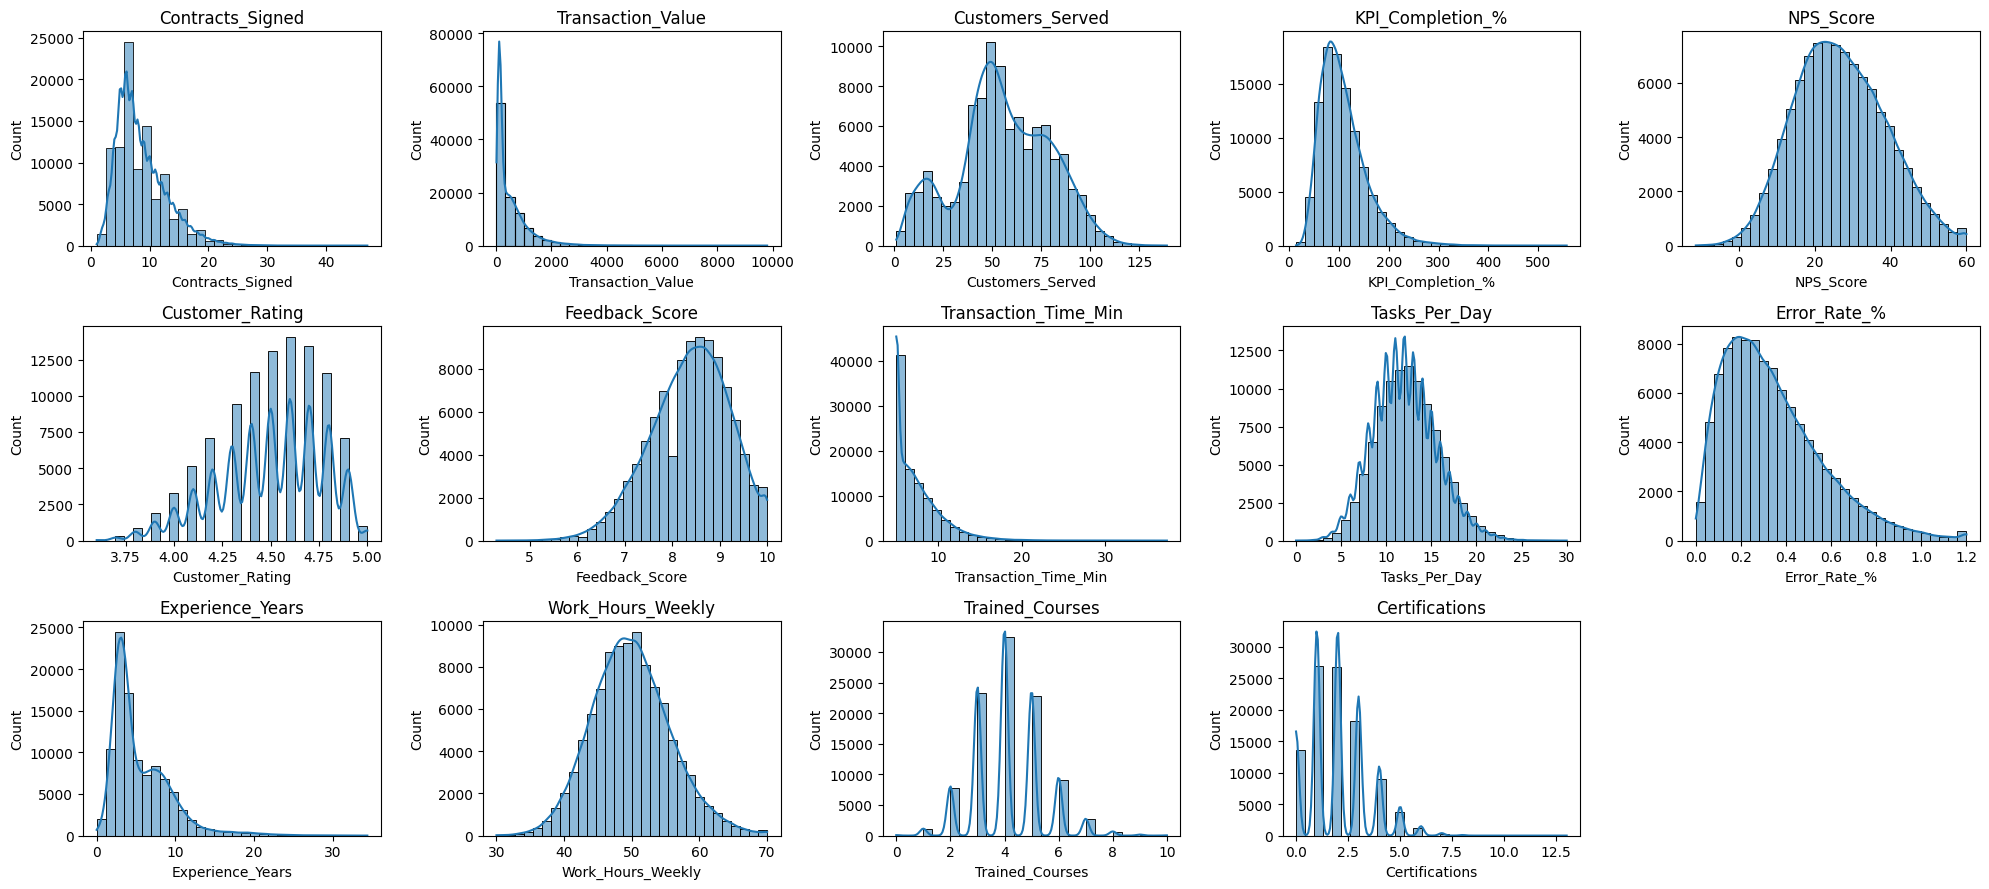

In [6]:
# Biểu đồ Phân phối
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
num_features = len(numerical_features)
cols = 5
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 3))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[feature].dropna(), kde=True, bins=30)
    plt.title(feature)
    plt.tight_layout()
plt.show()

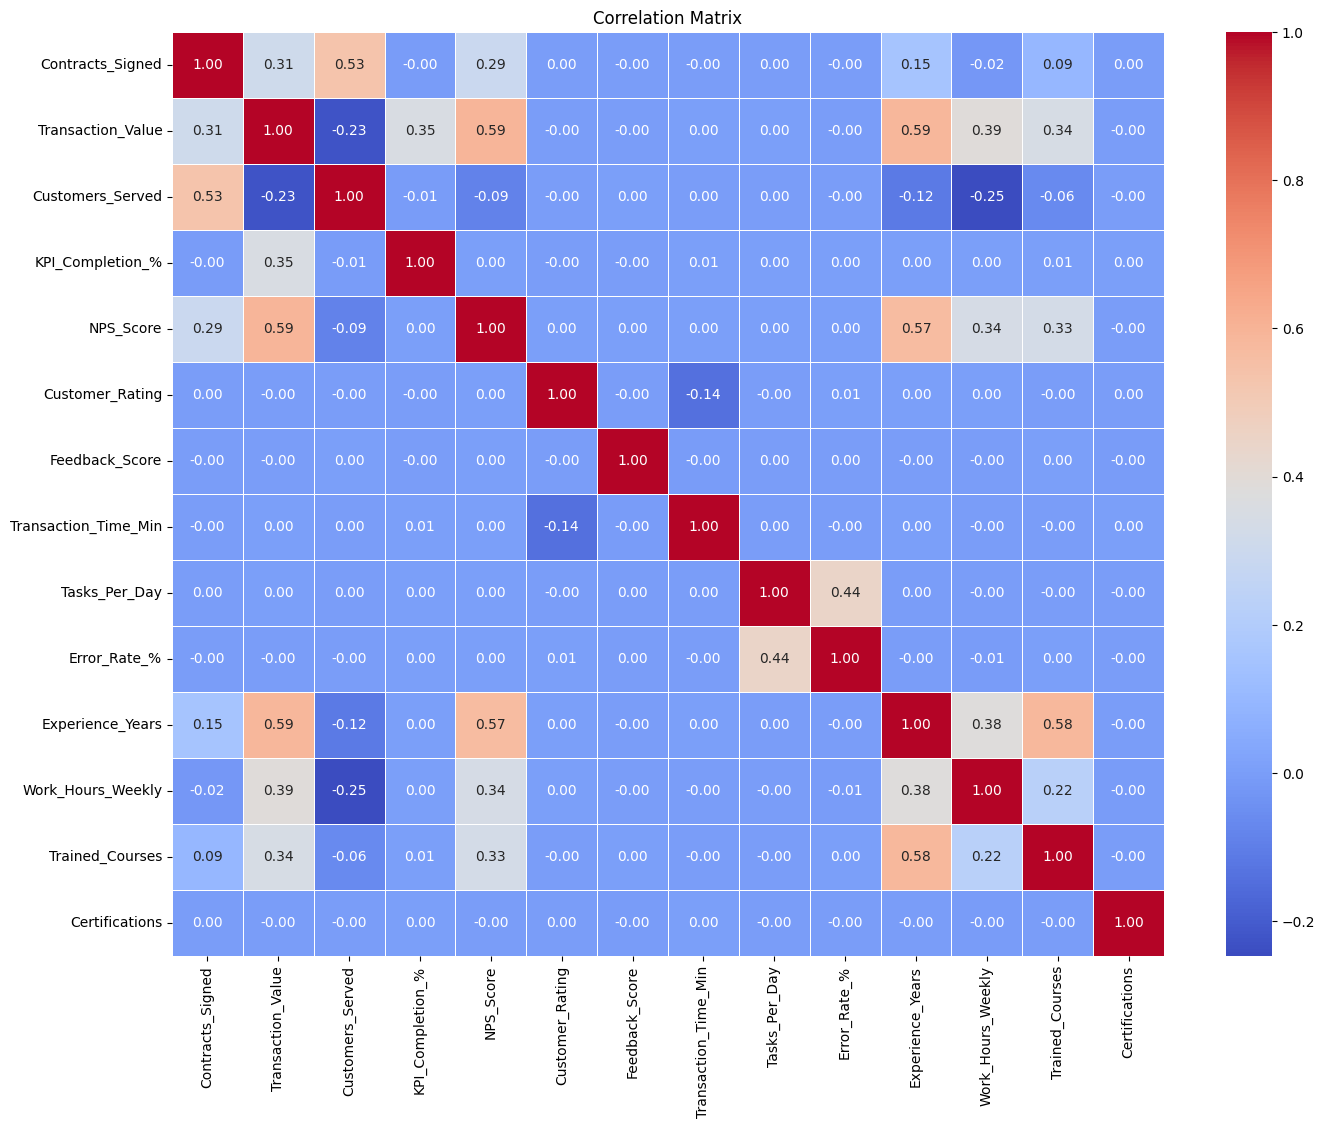

In [7]:
# Biểu đồ Ma trận tương quan
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

---
## **1.4: MÔ PHỎNG CỘT Y TARGET - NHÃN CẦN DỰ BÁO: PERFORMANCE_RATING**
- **YÊU CẦU**
    - Dữ liệu nhãn phân loại cần phải hợp lý để sau này mô hình học được đúng cách "ánh xạ"
    - Cột nhãn này không thể để ngẫu nhiên được, phải đúng với logic thực tế, có mối quan hệ với các biến đầu vào ở trên
- **Ý TƯỞNG**
    - Tham khảo theo cách doanh nghiệp/ngân hàng Việt Nam tính KPI: đề ra chỉ tiêu, ghi nhận chỉ số, quy đổi theo thang đo, nhân hệ số, cắt ngưỡng bằng Excel
    - Tác giả mô hình bằng phương pháp tương tự: Lấy những cột quan trọng, nhân trọng số tùy theo mức độ quan trọng, cắt threshold

In [8]:
# Hàm chuẩn hóa min-max
def normalize_min_max(series):
    return (series - series.min()) / (series.max() - series.min())

# Hàm chuẩn hóa đảo ngược (càng thấp càng tốt)
def normalize_inverse_min_max(series):
    return 1 - ((series - series.min()) / (series.max() - series.min()))

# Chuẩn hóa các cột cần thiết
df['contracts_norm'] = normalize_min_max(df['Contracts_Signed'])
df['transaction_norm'] = normalize_min_max(df['Transaction_Value'])
df['KPI_norm'] = normalize_min_max(df['KPI_Completion_%'])
df['NPS_norm'] = normalize_min_max(df['NPS_Score'])
df['Customer_Rating_norm'] = normalize_min_max(df['Customer_Rating'])
df['Feedback_norm'] = normalize_min_max(df['Feedback_Score'])

# Chuẩn hóa đảo ngược cho các cột "càng thấp càng tốt"
df['Transaction_Time_Inv'] = normalize_inverse_min_max(df['Transaction_Time_Min'])
df['Error_Rate_Inv'] = normalize_inverse_min_max(df['Error_Rate_%'])

# Định nghĩa trọng số cho từng chỉ số (tổng = 1)
weights = {
    'contracts': 0.05,
    'transactions': 0.05,
    'KPI': 0.5,               
    'NPS': 0.1,               
    'Customer_Rating': 0.05,   
    'Feedback': 0.05,          
    'Transaction_Time': 0.05, 
    'Error_Rate': 0.05       
}

# Tính điểm tổng hợp
df['Composite_Score'] = (
    df['contracts_norm'] * weights['contracts'] +
    df['transaction_norm'] * weights['transactions'] +
    df['KPI_norm'] * weights['KPI'] +
    df['NPS_norm'] * weights['NPS'] +
    df['Customer_Rating_norm'] * weights['Customer_Rating'] +
    df['Feedback_norm'] * weights['Feedback'] +
    df['Transaction_Time_Inv'] * weights['Transaction_Time'] +
    df['Error_Rate_Inv'] * weights['Error_Rate']
)

- **SETTING PHÂN PHỐI Ở ĐÂY, THAY ĐỔI CÁC MỨC CẮT THRESHOLD ĐỂ THAY ĐỔI SỐ LƯỢNG CHO CẢ 4 NHÃN**

In [9]:
# Xác định ngưỡng phân loại
rating_bins = [-np.inf, 0.23, 0.29, 0.36, np.inf]  # Tương ứng với Kém, Trung Bình, Tốt, Xuất Sắc 
rating_labels = ['Kém', 'Trung Bình', 'Tốt', 'Xuất Sắc'] # Nếu thử với bài toán KPI thì dùng bin và phân phối này

# Phân loại nhân viên
df['Performance_Rating'] = pd.cut(
    df['Composite_Score'],
    bins=rating_bins,
    labels=rating_labels,
    right=False  
)

# Hiển thị phân phối Performance Rating
performance_counts = df['Performance_Rating'].value_counts().sort_index().reset_index()
performance_counts.columns = ['Performance_Rating', 'Count']
display(performance_counts)

,Performance_Rating,Count
0,Kém,5095
1,Trung Bình,40384
2,Tốt,42232
3,Xuất Sắc,12289


In [10]:
##############################
# CẢNH BÁ0 VỀ PHÂN PHỐI NHÃN #        
##############################

# SAU NÀY KHI LÀM CÁC BÀI TOÁN KHÁC NHƯ DỊCH CHUYỂN NHÓM NỢ SẼ BỊ LỆCH PHÂN PHỐI NẶNG
# PHÂN PHỐI CỦA NHÓM NỢ CÁC NGÂN HÀNG SẼ NHƯ SAU:
#	Nhóm 1 – Nợ đủ tiêu chuẩn	    92–95%
#   Nhóm 2 – Nợ cần chú ý	        2–3%
#   Nhóm 3 – Dưới tiêu chuẩn	    1%
#   Nhóm 4 – Nợ nghi ngờ	        0.5%
#   Nhóm 5 – Có khả năng mất vốn	0.3–0.5%

# VÌ VẬY TA SẼ TÁCH RA LÀM 2 BÀI TOÁN
# 1. DỊCH CHUYỂN TỪ NHÓM 1 SANG 2 (NHỊ PHÂN)
# 2. DỊCH CHUYỂN GIỮA CÁC NHÓM 2 3 4 5 (NHIỀU NHÃN)
# KHI ĐÓ, NHÃN GIỮA 4 LỚP PHÍA SAU SẼ KHÁ ĐỀU ~ 10-45%, GIỐNG VỚI BÀI TOÁN KPI NÀY

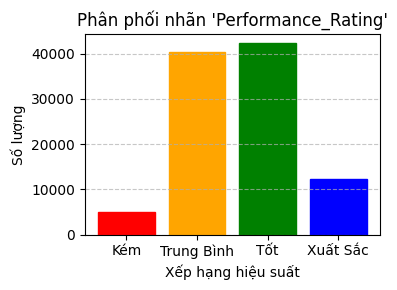

In [11]:
# Tính phân phối
performance_counts = df['Performance_Rating'].value_counts().sort_index().reset_index()
performance_counts.columns = ['Performance_Rating', 'Count']

# Vẽ biểu đồ
plt.figure(figsize=(4, 3))
bars = plt.bar(performance_counts["Performance_Rating"], performance_counts["Count"])

# Tô màu khác nhau cho từng cột
colors = ["red", "orange", "green", "blue"]
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.title("Phân phối nhãn 'Performance_Rating'")
plt.xlabel("Xếp hạng hiệu suất")
plt.ylabel("Số lượng")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Xóa các cột trung gian
df.drop(columns=['contracts_norm', 'transaction_norm', 'KPI_norm', 'NPS_norm', 'Customer_Rating_norm', 'Feedback_norm',
                 'Transaction_Time_Inv', 'Error_Rate_Inv', 'Composite_Score'], inplace=True, errors='ignore')

---
# <div align="center">**2. MÔ HÌNH PHÂN LOẠI**</div>   
---

## **2.1: LƯU Ý VỀ TRAIN TEST SPLIT (QUAN TRỌNG)**
- **PIPELINE KHI SỬ DỤNG MAPIE**
    - Mapie Clf ở phần 3 cần sử dụng thêm 1 tập Cal, viết tắt của Calibration
    - Tạm thời chỉ cần nhớ: thay vì chia thành 2 tập Train/Test - 70/30, 75/25, 80/20, ... như mọi khi thì ta cần chia thêm tập Cal nhỏ nữa
- **CÁCH CHIA** 
    - Tỷ lệ: chia 2 lần, chia tập lớn nào trước cũng được, tự nhân hệ số ra  % mong muốn, 
    - Lưu ý: cần chia sao thỏa mãn
        - Tập train đủ lớn để mô hình đủ thông tin học
        - Tập test đủ lớn để mô hình đánh giá dự báo phía sau
        - Tập cal vừa để mô hình Mapie Clf học cách dự báo Pred Set
    - Tạm thời, khuyến cáo tỷ lệ ví dụ như: Train/Cal/Test ~ 60/15/25 
- **GHI NHỚ RẰNG: "CẦN CHIA THÊM 1 TẬP CAL (CALIBRATION) ĐỂ SAU NÀY DÙNG CHO MAPIE CLF"**

In [13]:
from sklearn.model_selection import train_test_split
# Drop cột không cần thiết
df1 = df.drop(columns=["Employee_ID", "Position"])    # Lười chuẩn hóa cột Position, drop luôn :"3

# Tách nhãn và đặc trưng
y = df1["Performance_Rating"]
X = df1.drop(columns=["Performance_Rating"])

# Bước 1: chia train + cal (75%) và test (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.25,      # Lấy tập test 25% trước
    random_state=42,  
    stratify=y           # Đảm bảo cột y tách ra được phân phối đúng tỷ lệ 
)

# Bước 2: chia tiếp train (60%) và cal (15%) từ tập còn lại
# Lưu ý tỉ lệ: tự nhân chia, ví dụ nếu muốn train 60% thì lấy 75% (từ bước 1) * 0.8
X_train, X_cal, y_train, y_cal = train_test_split(
    X_temp, y_temp, 
    test_size=0.2,       # Lấy tập train/cal = 60%/15% 
    random_state=42, 
    stratify=y_temp
)


# Kiểm tra kích thước
print("Train:", X_train.shape)
print("Cal:  ", X_cal.shape)
print("Test: ", X_test.shape)

Train: (60000, 14)
Cal:   (15000, 14)
Test:  (25000, 14)


---
## **2.2: XÂY DỰNG MÔ HÌNH LÕI**
- **PIPELINE KHI SỬ DỤNG MAPIE**
    - Tác giả giả định người đọc đã quen với các bài phân loại - Classification - và có thể tự thực hiện các bước như
        - Lựa chọn biến đầu vào
        - Chuẩn hóa
        - Huấn luyện mô hình bằng tập X/y_train
        - Đánh giá mô hình bằng tập X/y_test
    - Notebook này sẽ tập trung vào Mapie Clf (Phần 3) 
- **GHI NHỚ RẰNG: "TRAIN MODEL VÀ ĐÁNH GIÁ QUA TẬP TEST NHƯ MỌI KHI, CHỌN RA MODEL CÓ CHỈ SỐ TỐT NHẤT"**

In [14]:
# Chuẩn hóa Y
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_cal_enc   = le.transform(y_cal)  
y_test_enc  = le.transform(y_test)

In [15]:
# Khởi tạo các mô hình
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
}

# Fit các mô hình trên tập train
fitted_models = {}

for name, model in models.items():
    print(f"Fitting {name}...")
    model.fit(X_train, y_train_enc)
    fitted_models[name] = model
print("Done bro!")    

Fitting RandomForest...
Fitting XGBoost...
Done bro!


In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Khởi tạo danh sách lưu kết quả
results = []
for name, model in fitted_models.items():
    y_test_pred = model.predict(X_test) 
    
    acc = accuracy_score(y_test_enc, y_test_pred)
    prec = precision_score(y_test_enc, y_test_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_enc, y_test_pred, average='weighted')  
    f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1_weighted": round(f1, 4)
    })

# Tạo bảng kết quả
results_df = pd.DataFrame(results).sort_values(by="F1_weighted", ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1_weighted
0,XGBoost,0.9640,0.9640,0.9640,0.9638
1,RandomForest,0.9162,0.9175,0.9162,0.9148


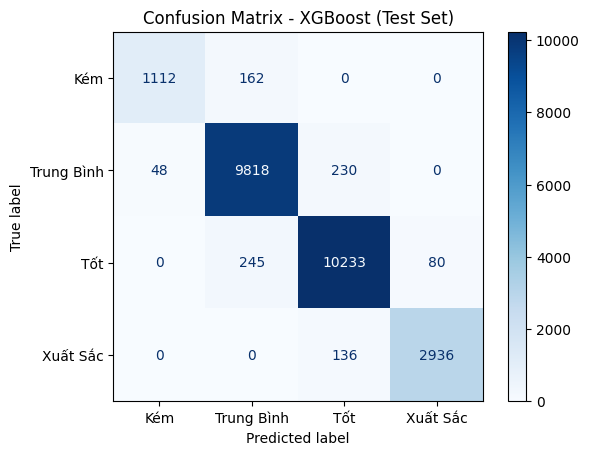

In [17]:
# Lấy model XGBoost (BEST MODEL) đã train
xgb_model = fitted_models["XGBoost"]
y_test_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test_enc, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.grid(False)
plt.show()

- **THU ĐƯỢC MÔ HÌNH TỐT NHẤT HIỆN TẠI LÀ: XGBOOST**

---
## **2.3: LƯU Ý VỀ ĐỘ CHÍNH XÁC CỦA MÔ HÌNH (QUAN TRỌNG)**
- **KẾT QUẢ DỰ BÁO**
    - Bản chất mô hình phân loại khi dự báo thằng X_test bất kỳ, luôn trả về "xác suất mà nó có thể được xếp vào từng class" - y_proba - PROBCLASS như trong bảng ở dưới
    - Sau đó tự động cắt threshold 0.5 thu được nhãn dự báo y_pred cuối cùng
    - Cuối cùng so sánh nhãn dự báo y_pred với nhãn thật y_test thu được bảng metric Accuracy, F1 và Confusion Matrix mà ta vẫn thường thấy như ở trên

In [18]:
# Lấy model XGBoost (BEST MODEL) đã train
xgb_model = fitted_models["XGBoost"]

# Predict
y_proba = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)
n_classes = y_proba.shape[1]
proba_cols = [f"Prob Class {i}" for i in range(n_classes)]

# Tạo DataFrame
df_pred = pd.DataFrame(y_proba, columns=proba_cols)
df_pred["y true"] = y_test_enc
df_pred["y pred"] = y_pred
df_pred = df_pred[["y true"] + proba_cols + ["y pred"]]
df_pred.head(10).style \
    .format({col: "{:.4f}" for col in proba_cols}) \
    .background_gradient(subset=proba_cols, cmap="YlGn") \
    .set_properties(**{'text-align': 'center'})


,y true,Prob Class 0,Prob Class 1,Prob Class 2,Prob Class 3,y pred
0,1,0.0000,0.9970,0.0030,0.0000,1
1,3,0.0000,0.0000,0.0001,0.9999,3
2,1,0.2604,0.7396,0.0000,0.0000,1
3,1,0.0001,0.9994,0.0005,0.0000,1
4,0,0.6058,0.3942,0.0000,0.0000,0
5,2,0.0000,0.0000,0.9410,0.0589,2
6,2,0.0000,0.0724,0.9276,0.0001,2
7,3,0.0000,0.0001,0.0008,0.9991,3
8,1,0.0001,0.9999,0.0000,0.0000,1
9,1,0.0000,0.9954,0.0046,0.0000,1


- **SAI SỐ CHẤP NHẬN**
    - Vậy thì những thằng X/y_test dự báo bị sai thì sao? Rõ ràng là khi triển khai thực tế thì ta không thể biết được, không hề có nhãn y_true để ta kiểm tra
    - Ta phải chấp nhận rằng dù là mô hình hay con người luôn luôn có sai số, chỉ đạt được 9x % chính xác
- **VẤN ĐỀ NẢY SINH**
    - Vậy nếu khách hàng/đối tác yêu cầu trả về các hồ sơ nghi ngờ để xem xét duyệt thì ta trả về như thế nào? Mô hình đáng tin đến mức nào họ không biết được
    - Ví dụ có những thằng X mà mô hình dự báo ra class0 60%, class1 40% tức là mô hình đang phân vân giữa 2 class này
    - Có nên trả về hay không? Hay dự báo nó là class0 cũng được? Rất khó nói đúng không?
    - Vậy thì chỉ cần setting thêm phần cắt ngưỡng, nếu max(y_proba)< 75% thì trả hồ sơ về chẳng hạn? Nhưng cách này khá là chủ quan, không ổn chút nào
- **GIẢI QUYẾT**
    - Ta sử dụng 1 model phụ là MAPIE CLASSIFICATION, (cắt ngưỡng linh hoạt) dự báo ra PREDICTION SET - tập nhãn dự báo - cho những thằng X mà mô hình phân vân, từ đó trả những thằng X này về cho khách hàng/đối tác xem xét
- **GHI NHỚ RẰNG: "CHÚNG TA TRAIN MODEL LÕI CHỌN RA MODEL TỐT NHẤT, KIỂM TRA ĐỘ TIN CẬY CỦA NÓ BẰNG MAPIE CLF"**

---
# <div align="center">**3. MAPIE CLF UNDERSTANDING**</div>   
---

## **3.0: THÔNG TIN CHI TIẾT**
- **LINK ENG**
    - https://mapie.readthedocs.io/en/latest/examples_classification/4-tutorials/plot_main-tutorial-classification.html
    - https://mapie.readthedocs.io/en/latest/generated/mapie.classification.MapieClassifier.html
- **THUẬT TOÁN Ý TƯỞNG**
    - Mô hình tốt nhất đã huấn luyện từ tập train là **xgb_model**
    - Mapie dùng **xgb_model** dự báo **X_cal** ra xác suất **y_cal_proba** 
        - Tính sai số giữa **y_cal_proba** vs **y_cal**
        - Thu được **nonconformity** là phân phối sai số - sai số giữa "xác suất dự đoán" so với "nhãn thật"
        - Cài đặt **alpha = 0.05** (chẳng hạn)
        - Với ý tưởng từ độ tin cậy, lấy **Q** là phân vị 95% của phân phối sai số này
    - Mapie dùng **xgb_model** dự báo **X_test** ra xác suất **y_test_proba** 
        - Cộng trừ **Q** vào 2 phía của **y_test_proba** tạo khoảng **proba upper/lower** cho **y_test_proba**
        - Cắt ngưỡng linh hoạt thu được **Prediction Set**
- **THUẬT TOÁN NGẮN GỌN**
    - Fit MapieClassifier bằng tập Cal
    - Predict Set cho tập Test
- **GHI NHỚ RẰNG: "MODEL LÕI FIT BẰNG TẬP TRAIN => MAPIE CLF FIT BẰNG TẬP CAL => PREDICT SET CHO TẬP TEST"**

---

## **3.1: FIT MAPIE CLF**
- **CÁC SETTING HIỆN TẠI**
    - **estimator:** Dùng model lõi tốt nhất đã chốt ở Phần 2 là **xgb_model**
    - **cv & method::** Giải thích rất dài, hỏi chatgpt hoặc đọc link tài liệu bên trên. Tạm thời khuyến cáo dùng setting phổ thông nhất như trong code

In [19]:
from mapie.classification import MapieClassifier

# Wrap mô hình đã train vào MAPIE
mapie_clf = MapieClassifier(
    estimator=xgb_model,            # Sử dụng best model đã chốt từ Phần 2
    method="score",                 
    cv="prefit"                     # Sử dụng best model đã chốt từ Phần 2
)

# Fit MAPIE trên tập calibration
mapie_clf.fit(X_cal, y_cal_enc)     # Tại đây mapie sẽ tính được nonconformity và Q

MapieClassifier(cv='prefit',
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='mlogloss',
                                        feature_types=None,
                                        feature_weights=None, gamma=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None, ...),
                method='score')

---

## **3.2: PREDICTION SET**
- **CODE RÚT GỌN**
    - Tác giả code dài để phân tích trực quan cho anh em dễ hiểu, thực tế chỉ cần cột PRED SET
- **ĐỘ TIN CẬY**
    - Anh em tự thay đổi alpha ngay trong tài liệu này hoặc các bài tương tự để hiểu với các độ tin cậy khác nhau thì PRED SET thay đổi như nào

In [20]:
# THAY ĐỔI ALPHA TẠI ĐÂY ĐỂ HIỂU ĐƯỢC KẾT QUẢ PRED SET SẼ THAY ĐỔI NHƯ NÀO KHI ALPHA THAY ĐỔI
# HIỆN TẠI ĐANG DÙNG ĐỘ TIN CẬY 0.99 = 99% ĐỂ TRỰC QUAN CÁC ĐỦ 2 TRƯỜNG HỢP ĐỎ VÀNG XANH
alpha = 0.01

# 1. Dự đoán từ mô hình MAPIE
y_pred_mapie, y_pset = mapie_clf.predict(X_test, alpha=alpha)

# 2. Lấy xác suất từ model gốc
y_proba = xgb_model.predict_proba(X_test)

# 3. Tạo DataFrame kết quả
n_classes = y_proba.shape[1]
proba_cols = [f"Prob Cass {i}" for i in range(n_classes)]

df_result = pd.DataFrame(y_proba, columns=proba_cols)
df_result["y true"] = y_test_enc  # hoặc: le.inverse_transform(y_test_enc) nếu muốn nhãn dạng chữ

# 4. Convert prediction set thành set chỉ mục class
df_result["Prediction Set"] = [
    set(np.where(row == 1)[0]) 
    for row in y_pset
]

# 2) Ép mọi phần tử trong set về int thường
df_result["Prediction Set"] = df_result["Prediction Set"].apply(
    lambda s: {int(x) for x in s}
)

# Sắp xếp lại thứ tự cột
cols_order = ["y true"] + proba_cols + ["Prediction Set"]
df_result = df_result[cols_order]

# Tính logic bổ sung
df_result["Set size"] = df_result["Prediction Set"].apply(len)
df_result["Correct in set"] = [
    y in s for y, s in zip(df_result["y true"], df_result["Prediction Set"])
]

# Trực quan
styled = (
    df_result.head(20)
    .style
    .background_gradient(subset=proba_cols, cmap=custom_green)
    .format(precision=2, subset=proba_cols)
    # Dòng mới: convert 'Prediction Set' thành chuỗi
    .format(lambda x: str(x), subset=["Prediction Set"])  
    .apply(highlight_warning_full, axis=1)
    .set_properties(**{'text-align': 'center'})
    .hide(axis="index")
)
styled

y true,Prob Cass 0,Prob Cass 1,Prob Cass 2,Prob Cass 3,Prediction Set,Set size,Correct in set
1,0.00,1.00,0.00,0.00,{1},1,True
3,0.00,0.00,0.00,1.00,{3},1,True
1,0.26,0.74,0.00,0.00,{1},1,True
1,0.00,1.00,0.00,0.00,{1},1,True
0,0.61,0.39,0.00,0.00,"{0, 1}",2,True
2,0.00,0.00,0.94,0.06,{2},1,True
2,0.00,0.07,0.93,0.00,{2},1,True
3,0.00,0.00,0.00,1.00,{3},1,True
1,0.00,1.00,0.00,0.00,{1},1,True
1,0.00,1.00,0.00,0.00,{1},1,True


In [24]:
alpha = 0.001

# 1. Dự đoán từ mô hình MAPIE
y_pred_mapie, y_pset = mapie_clf.predict(X_test, alpha=alpha)

# 2. Lấy xác suất từ model gốc
y_proba = xgb_model.predict_proba(X_test)

# 3. Tạo DataFrame kết quả
n_classes = y_proba.shape[1]
proba_cols = [f"Prob Cass {i}" for i in range(n_classes)]

df_result = pd.DataFrame(y_proba, columns=proba_cols)
df_result["y true"] = y_test_enc  # hoặc: le.inverse_transform(y_test_enc) nếu muốn nhãn dạng chữ

# 4. Convert prediction set thành set chỉ mục class
df_result["Prediction Set"] = [
    set(np.where(row == 1)[0]) 
    for row in y_pset
]

# 2) Ép mọi phần tử trong set về int thường
df_result["Prediction Set"] = df_result["Prediction Set"].apply(
    lambda s: {int(x) for x in s}
)

# Sắp xếp lại thứ tự cột
cols_order = ["y true"] + proba_cols + ["Prediction Set"]
df_result = df_result[cols_order]

# Tính logic bổ sung
df_result["Set size"] = df_result["Prediction Set"].apply(len)
df_result["Correct in set"] = [
    y in s for y, s in zip(df_result["y true"], df_result["Prediction Set"])
]

# Trực quan
styled = (
    df_result.head(20)
    .style
    .background_gradient(subset=proba_cols, cmap=custom_green)
    .format(precision=2, subset=proba_cols)
    # Dòng mới: convert 'Prediction Set' thành chuỗi
    .format(lambda x: str(x), subset=["Prediction Set"])  
    .apply(highlight_warning_full, axis=1)
    .set_properties(**{'text-align': 'center'})
    .hide(axis="index")
)
styled

y true,Prob Cass 0,Prob Cass 1,Prob Cass 2,Prob Cass 3,Prediction Set,Set size,Correct in set
1,0.00,1.00,0.00,0.00,{1},1,True
3,0.00,0.00,0.00,1.00,{3},1,True
1,0.26,0.74,0.00,0.00,"{0, 1}",2,True
1,0.00,1.00,0.00,0.00,{1},1,True
0,0.61,0.39,0.00,0.00,"{0, 1}",2,True
2,0.00,0.00,0.94,0.06,"{2, 3}",2,True
2,0.00,0.07,0.93,0.00,"{1, 2}",2,True
3,0.00,0.00,0.00,1.00,{3},1,True
1,0.00,1.00,0.00,0.00,{1},1,True
1,0.00,1.00,0.00,0.00,{1},1,True


- **KẾT QUẢ TRỰC QUAN**
    - Nhìn vào cột Prediction Set:
        - Màu xanh: Pred Set trả về 1 nhãn duy nhất và nó đúng chính xác nhãn thật y_test
        - Màu vàng: Pred Set trả về 2 nhãn trở lên và nó "chứa" đúng y_test trong đó.
        - Màu đỏ: Pred Set trả về một hay nhiều nhãn nào đó nhưng không hề chứa y_test tức là dự báo sai hoàn toàn.
    - Ý nghĩa:
        - Màu xanh: mô hình dự báo 1 nhãn và "trúng phóc"
        - Màu vàng: mô hình dự báo nhiều nhãn và chắc chắn rằng nhãn thật nằm trong đó (mô hình phân vân, trả về cho người xem xét)
        - Màu đỏ: thực tế ta không hề biết là những dòng này nằm ở đâu khi triển khai, đây chỉ đơn giản là sai số phải chấp nhận, dù mô hình trả về 1 hay nhiều nhãn thì vẫn có thể có những trường hợp là nhãn thật không hề nằm trong Set
- **ĐIỂM MẤU CHỐT**        
    - Mapie giúp ta trả về những dòng màu vàng để con người xem xét thay vì dự báo 1 nhãn và chấp nhận sai số
    - Chuyển hóa **"sai số chấp nhận"** (màu đỏ alpha = 0.01) thành **"rủi ro phát hiện" / "hồ sơ xem xét"** (màu vàng alpha = 0.001)
- **SỰ ĐÁNH ĐỔI**
    - Thực chất mô hình lõi **xgb_model** ban đầu chính là trả về Pred set chỉ chứa 1 nhãn y_pred, và chỉ tô màu xanh & đỏ cho bảng này
    - Khi độ tin cậy tăng thì mô hình "sợ sai" nên phải tạo ra thêm nhiều Pred Set chứa từ 2 nhãn trở lên
    - Vậy là ta chấp nhận thêm nhiều dòng bị trả về xem xét để giảm sai số chấp nhận
    - Tuy nhiên điều này làm cho nhiều dòng đáng ra là "trúng phóc" rồi (màu xanh alpha = 0.01) lại bị trở thành "hồ sơ xem xét" (màu vàng alpha = 0.001)
- **CÂU HỎI VỀ CHÍNH SÁCH**
    - Vậy thì nên Setting alpha & độ tin cậy như nào để mô hình cần bằng trong việc tự tin "trả về hồ sơ" vs "giảm sai số"
    - Ta tìm bằng cách: tại mọi alpha, ta tính
        - Độ bao phủ - coverage
        - Số nhãn trả về trung bình - width 
    - Như trong đoạn code dưới đây

In [22]:
from mapie.metrics import classification_coverage_score, classification_mean_width_score

# 1. Tạo alpha grid
alpha_grid = np.arange(0.005, 1, 0.005)

# 2. Dự đoán prediction set cho toàn bộ alpha
_, y_ps_all = mapie_clf.predict(X_test, alpha=alpha_grid)

# 3. Tính coverage và width cho mỗi alpha
coverages = [
    classification_coverage_score(y_test_enc, y_ps_all[:, :, i])
    for i in range(len(alpha_grid))
]
widths = [
    classification_mean_width_score(y_ps_all[:, :, i])
    for i in range(len(alpha_grid))
]

# 4. Tạo bảng kết quả
df_alpha_analysis = pd.DataFrame({
    "alpha": alpha_grid,
    "Coverage": coverages,
    "Avg_Set_Width": widths
})

display(df_alpha_analysis.head(10).style.format({
    "alpha": "{:.3f}",
    "Coverage": "{:.4f}",
    "Avg_Set_Width": "{:.2f}"
}))

,alpha,Coverage,Avg_Set_Width
0,0.005,0.9951,1.13
1,0.010,0.9899,1.08
2,0.015,0.9848,1.06
3,0.020,0.9807,1.04
4,0.025,0.9750,1.03
5,0.030,0.9704,1.01
6,0.035,0.9661,1.00
7,0.040,0.9614,0.99
8,0.045,0.9554,0.98
9,0.050,0.9495,0.97


- **COVERAGE - ĐỘ BAO PHỦ**
    - Tại 1 dòng bất kỳ, Pred Set "chứa" y_test thì trả về True, rồi tính True/All
    - Càng nhiều dòng có Pred Set "chứa" y_test thì Coverage càng cao
    - Nói dễ hiểu, đây là ***"độ chính xác trong việc bao phủ: dự báo ra được tập nhãn có chứa nhãn thật"***
- **WIDTH - SỐ NHÃN DỰ BÁO TRUNG BÌNH**
    - Tính trung bình của Set Size
    - Càng nhiều dòng có Set Size > 1 thì Width càng tăng
    - Nói dễ hiểu, đây là ***"số nhãn được trả về trung bình"***
- **GIẢI THÍCH Ý NGHĨA BẢNG**
    - **Tại mọi alpha:** ta thấy coverage xấp xỉ độ tin cậy 1-alpha
        - Đây là điều tự nhiên vì Mapie dùng chính ý tưởng từ độ tin cậy để tạo hộp đen 
        - Về mặt lý thuyết: coverage sẽ luôn xấp xỉ độ tin cậy nếu ta setting mô hình mapie đúng, đây chính là % số dòng màu xanh
    - **Tại alpha 0.035:** ta thấy width = 1
        - Tức là trung bình mỗi dòng mô hình chỉ dự báo 1 nhãn cho Pred set
        - Đây chính là trường hợp lõi xgb_model ban đầu, với độ chính xác là 96,6% dòng màu xanh, còn lại là màu đỏ, không có lõi màu vàng
        - Thực ra là có dòng màu vàng nhưng cực hiếm - Width ~ 1.0001
    - **Khi giảm alpha - tăng độ tin cậy:** ta thấy width tăng mạnh dần
        - Mô hình sợ sai, phải mở rộng sai số Q 2 phía để bao phủ đủ % trường hợp - tăng nhiều Pred set 2 nhãn - tăng số hồ sơ trả về
        - Coverage càng gần 100% (không bao giờ đạt được), Width tăng càng mạnh


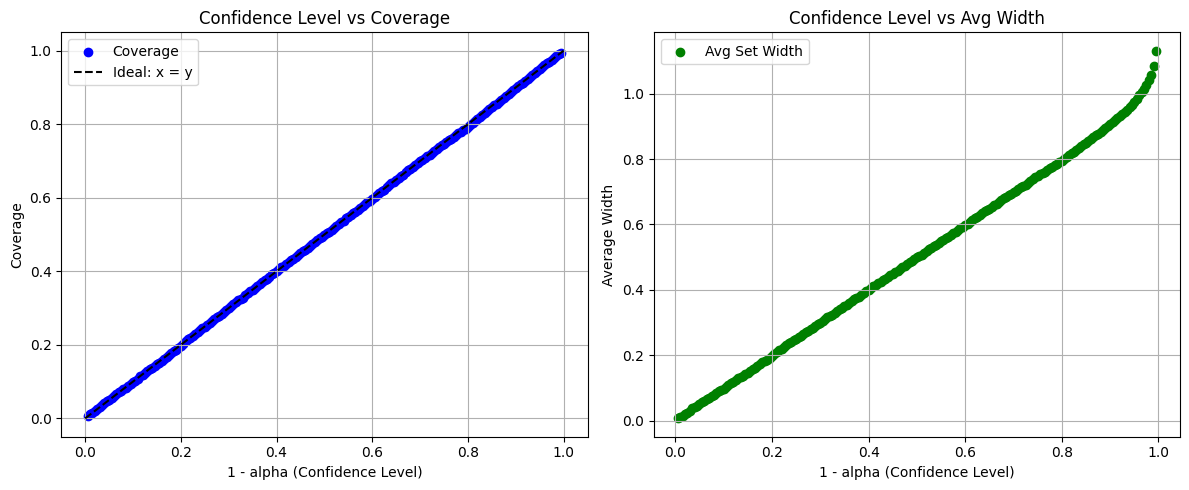

In [23]:
# Vẽ 2 biểu đồ tách biệt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 1. Biểu đồ Coverage
axs[0].scatter(1 - alpha_grid, coverages, color="blue", label="Coverage")
axs[0].plot([0, 1], [0, 1], 'k--', label="Ideal: x = y")
axs[0].set_xlabel("1 - alpha (Confidence Level)")
axs[0].set_ylabel("Coverage")
axs[0].set_title("Confidence Level vs Coverage")
axs[0].legend()
axs[0].grid(True)

# 2. Biểu đồ Width
axs[1].scatter(1 - alpha_grid, widths, color="green", label="Avg Set Width")
axs[1].set_xlabel("1 - alpha (Confidence Level)")
axs[1].set_ylabel("Average Width")
axs[1].set_title("Confidence Level vs Avg Width")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

- **ĐỒ THỊ COVERAGE & WIDTH THEO ĐỘ TIN CẬY**
    - Khi fit mapie, có thể người thực hành sẽ nhầm ở đâu đó, ta cần in ra đồ thị coverage và width để kiểm tra 
    - Lý tưởng với hầu hết bộ dữ liệu: 
        - Coverage xấp xỉ/trùng với độ tin cậy 1-alpha 
        - Width có đoạn cuối bị vểnh lên tăng mạnh
            - Đây chính là hiện tượng trả về quá nhiều nhãn do mong muốn độ tin cậy tiệm cận lên 100% đã nêu ở trên
- **VÍ VON DỄ HIỂU**
    - Mô hình giống như 1 ông bác sĩ đa khoa:
        - Muốn đoán đúng bệnh cho cả 1000 bệnh nhân
        - Vì sợ sai nên ông ta đoán mỗi người 2 đến 3 bệnh và hứa rằng bệnh thật sẽ nằm trong số đó
        - Quá nhiều hồ sơ phải chuyển tiếp cho bác sĩ chuyên môn khác
    - Trả về quá nhiều thì quá phiền phức, ông bác sĩ đa khoa này "vô dụng" không giúp được gì (mô hình ML - quy trình AI không tự động hóa được, không khác gì bộ phận thẩm định thủ công ban đầu)
    - Vậy như nào là bác sĩ đa khoa giỏi? 
        - Là với mỗi bệnh nhân, chỉ đoán 1 bệnh và trúng phóc luôn, chính xác đến 96.6%. Chấp nhận sai số 3.4%
        - Hoặc cân bằng được giữa "số hồ sơ được trả về" và "sai số chấp nhận"
- **THẮC MẮC PHỤ**
    - Tại sao có những dòng mà Width < 1? 
        - Đây là những trường hợp nới lỏng quá, độ tin cậy thấp; mô hình thu hẹp khoảng upper lower, không dự đoán nhãn nào cả
        - Trả về pred set rỗng (), set size = 0
        - Hãy thử với alpha lớn để xem bảng pred set ở trên output như thế nào
    - Tuy nhiên, notebook này chưa đề cập tới cách tính thủ công hộp đen đó nên tạm hiểu rằng:
        - Không cần quan tâm, đây là những trường hợp "vứt đi", vừa coverage thấp, vừa phải trả về nhiều hồ sơ
        - Chỉ cần quan tâm rằng: những trường hợp có Width >= 1 là có thể áp dụng được thực tế

---

## **3.3: KẾT LUẬN NGẮN GỌN DỄ HIỂU**
- **MÔ HÌNH MAPIE ĐÃ KIỂM TRA ĐỘ TIN CẬY CỦA MÔ HÌNH XGB LÕI VÀ KHẲNG ĐỊNH RẰNG:**
    - "Nếu muốn hệ thống tự động hóa hoàn toàn (chỉ trả về 1 nhãn) thì mô hình đảm bảo **độ tin cậy/độ bao phủ/độ chính xác** lên đến 96.6% các trường hợp"
    - "Hãy cân nhắc giữa độ tin cậy mong muốn và số lượng hồ sơ phải xét duyệt, mô hình sẽ trả về một cách linh hoạt những trường hợp mà mô hình phân vân/không chắc chắn"
    - "Nếu muốn độ tin cậy 99%, mô hình sẽ in ra được Pred Set bao gồm 92% trường hợp chỉ trả về đúng 1 nhãn; 8% trường hợp trả hồ sơ gồm 2 nhãn cần con người xem xét. Và trong 100% này có thế có 1% sai số nào ở đâu đó không biết được mà ta phải chấp nhận"
- **TỔNG KẾT PIPELINE**
    - Notebook trình bày trực quan để hiểu ý tưởng chứ không hướng dẫn code
    - Chỉ cần nhớ các bước chính + tự thực hành ChatGPT/Claude/etcetc :"3
        - **Split** 3 tập train/cal/test
        - **Train** lõi 
        - **Test** chỉ số, chọn best model làm lõi
        - **Mapie** kiểm tra độ tin cậy của best model đó
            - **Cal fit mapie** 
            - Setting alpha single
                - In ra df gồm Predset và Proba và y test kiểm tra
                - Thử nghiệm thay alpha xem output thay đổi như nào
            - Setting alpha grid 
                - In ra df gồm Coverage và Width tại mọi alpha
                - Chọn alpha & độ tin cậy phù hợp chính sách mong muốn
- **FAQ**
    - Vô hạn, khuyến cáo GPT vừa tự code dự án tương tự, vừa dễ hỏi những thắc mắc liên quan tới phần đó :"3